In [1]:
#!pip install tensorflow
#!pip install fasttext
#!pip install mlxtend
#import nltk
#nltk.download("all")

In [2]:
#loading libraries
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import scipy.sparse as sp
from scipy.stats import uniform, randint

#loading visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
from statistics import mean, stdev
import plotly.graph_objects as go

#loading nltk libraries
import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from unicodedata import normalize

#loading scikit libraries
import sklearn
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score, make_scorer, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

#loading gensim libraries
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import FastText

import time
import warnings
warnings.filterwarnings('ignore')

## Loading Training and testing Data Files

In [3]:
#loading the training and testing file on a dataframe
train_data = pd.read_csv("C:/Users/ritac/Documents/Datasets/4a-english/4A-English/SemEval2017-task4-dev.subtask-A.english.INPUT.txt", 
                        sep="	", header=None, usecols=[1,2], names=["sentiments", "tweets"])

SemEval_test_data = pd.read_csv("C:/Users/ritac/Documents/Datasets/SemEval2017-task4-test.subtask-A.english.txt", 
                           sep="	", header=None, usecols=[1,2], names=["sentiments", "tweets"] )

### Train Data Description and shape

In [4]:
# getting the total number of sentiments for each class
train_data.sentiments.value_counts()

neutral     10342
positive     7059
negative     3231
Name: sentiments, dtype: int64

In [5]:
# extracting first five rows
train_data.head()

,sentiments,tweets
0,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T..."
1,neutral,Order Go Set a Watchman in store or through ou...
2,negative,If these runway renovations at the airport pre...
3,neutral,If you could ask an onstage interview question...
4,positive,A portion of book sales from our Harper Lee/Go...


In [6]:
#printing Data Shape
train_data.shape

(20632, 2)

### Test Data Description and shape

In [7]:
# counting the total number for each sentiment
SemEval_test_data.sentiments.value_counts()

neutral     5743
negative    3811
positive    2352
Name: sentiments, dtype: int64

In [8]:
# checking first five Rows of the data
SemEval_test_data.head()

,sentiments,tweets
0,neutral,#ArianaGrande Ari By Ariana Grande 80% Full ht...
1,positive,Ariana Grande KIIS FM Yours Truly CD listening...
2,positive,Ariana Grande White House Easter Egg Roll in W...
3,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...
4,neutral,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...


In [9]:
# Printing Data Shape
SemEval_test_data.shape

(11906, 2)

## Cleaning Training Data

In [10]:
#getting a description of the data before cleaning
train_data.describe(include="object")

,sentiments,tweets
count,20632,20632
unique,3,20552
top,neutral,Tomorrow Seth Rollins's WWE title reign will s...
freq,10342,2


In [11]:
# checking for empty rows
train_data.isna().sum()

sentiments    0
tweets        0
dtype: int64

In [12]:
#checking for duplicates
train_data.duplicated(subset="tweets").sum()

80

In [13]:
# removing duplicates from the training data
train_data = train_data.drop_duplicates(subset="tweets")

In [14]:
# getting a description of data after cleaning
train_data.describe(include="object")

,sentiments,tweets
count,20552,20552
unique,3,20552
top,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T..."
freq,10299,1


## Cleaning Test Data

In [15]:
#getting a description of the data before cleaning
SemEval_test_data.describe(include="object")

,sentiments,tweets
count,11906,11906
unique,3,11906
top,neutral,#ArianaGrande Ari By Ariana Grande 80% Full ht...
freq,5743,1


In [16]:
# checking for empty rows
SemEval_test_data.isna().sum()

sentiments    0
tweets        0
dtype: int64

In [17]:
#checking for duplicates
SemEval_test_data.duplicated(subset="tweets").sum()

0

In [18]:
# getting a description of data after cleaning
SemEval_test_data.describe(include="object")

,sentiments,tweets
count,11906,11906
unique,3,11906
top,neutral,#ArianaGrande Ari By Ariana Grande 80% Full ht...
freq,5743,1


## Data Preprocessing Function

In [19]:
#function for preprocessing tweets
def preprocess_text(data):
    preprocessed_tweets = []
    sentiment = []

    for index, tweet in data.iterrows():
        # Remove hashtags and mentions
        clean_tweets = re.sub(r"#\S+|@\S+", "", tweet.tweets)
        # Replace newlines with a space
        clean_tweets = clean_tweets.replace("\n", " ")
        # Remove URLs
        clean_tweets = re.sub(r"http\S+|www\S+|https\S+", "", clean_tweets)
        # Remove punctuation, symbols, and reduce whitespace
        clean_tweets = re.sub(r"[^\w\s]", " ", clean_tweets)
        clean_tweets = re.sub(r"\s+", " ", clean_tweets).strip()
        # Remove words with digits
        clean_tweets = re.sub(r"\b\w*\d\w*\b", "", clean_tweets)
        # Reduce repeated characters
        clean_tweets = re.sub(r'(.)\1+', r'\1\1', clean_tweets)
        
        # Convert to lower case
        clean_tweets = clean_tweets.lower()
        
        # Tokenize texts
        tokens = word_tokenize(clean_tweets)
        
        # Part-of-speech tagging
        tagged_tokens = pos_tag(tokens)

        # Initialize stop words
        stop_words = set(stopwords.words("english"))
        
        # Filter tokens based on POS tags and stop words
        # check if words with specific tags(Noun(N), adjective(J), verb(v), Adverbs(R)) is in tagged tokens and
        # not in stop words. select word and add to the selected tokens list
        selected_tokens = [word for word, pos in tagged_tokens if word not in stop_words and 
                           (pos.startswith('N') or pos.startswith('J') or pos.startswith('V') or pos.startswith('R'))]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in selected_tokens]
        
        # Join back tokens
        preprocessed_tweet = " ".join(lemmatized_tokens)
        
        # Attach sentiment and preprocessed tweet to designated lists
        sentiment.append(tweet.sentiments)
        preprocessed_tweets.append(preprocessed_tweet)

    # Create a new column in the dataframe called 'clean_tweets'
    data['clean_tweets'] = preprocessed_tweets

    # Function output
    return data

## Preprocess Train Data

In [20]:
# preprocessing the train data and assigning the cleaned tweets 
#to a new colum on the dataframe called clean tweets
clean_train_data = preprocess_text(train_data)

# print message
print("completed")

completed


In [21]:
# preprocessed tweets
clean_train_data.head()

,sentiments,tweets,clean_tweets
0,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T...",picturehouse pink floyd roger water wall openi...
1,neutral,Order Go Set a Watchman in store or through ou...,order go set watchman store website tuesday ge...
2,negative,If these runway renovations at the airport pre...,runway renovation airport prevent seeing taylo...
3,neutral,If you could ask an onstage interview question...,ask onstage interview question miss usa tomorrow
4,positive,A portion of book sales from our Harper Lee/Go...,portion book sale harper lee go set watchman r...


In [22]:
# create a new dataframe df_train and df_test that contains only the columns "sentiments" and "clean_tweets" 
# from the clean_train_data and clean_test_data dataframes.

df_train = clean_train_data[["sentiments", "clean_tweets"]]
df_train.head()

,sentiments,clean_tweets
0,neutral,picturehouse pink floyd roger water wall openi...
1,neutral,order go set watchman store website tuesday ge...
2,negative,runway renovation airport prevent seeing taylo...
3,neutral,ask onstage interview question miss usa tomorrow
4,positive,portion book sale harper lee go set watchman r...


## Preprocess Text Data

In [23]:
# preprocessing the train data and assigning the cleaned tweets 
#to a new colum on the dataframe called clean tweets
clean_test_data = preprocess_text(SemEval_test_data)

# print message
print("completed")

completed


In [24]:
# preprocessed tweets
clean_test_data.head()

,sentiments,tweets,clean_tweets
0,neutral,#ArianaGrande Ari By Ariana Grande 80% Full ht...,ari ariana grande full
1,positive,Ariana Grande KIIS FM Yours Truly CD listening...,ariana grande kiis fm truly cd listening party...
2,positive,Ariana Grande White House Easter Egg Roll in W...,ariana grande white house easter egg roll wash...
3,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...,ariana grande sweet candy oz ml sealed box aut...
4,neutral,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...,side side


In [25]:
# create a new dataframe df_train and df_test that contains only the columns "sentiments" and "clean_tweets" 
# from the clean_train_data and clean_test_data dataframes.

df_test = clean_test_data[["sentiments", "clean_tweets"]]
df_test.head()

,sentiments,clean_tweets
0,neutral,ari ariana grande full
1,positive,ariana grande kiis fm truly cd listening party...
2,positive,ariana grande white house easter egg roll wash...
3,positive,ariana grande sweet candy oz ml sealed box aut...
4,neutral,side side


## Data Exploration for training data

In [26]:
# Define a function to plot a pie chart showing the distribution of sentiment categories.
def plot_sentiment_pie(data):
    # Count the occurrences of each sentiment category in the 'sentiments' column of the DataFrame.
    sentiment_counts = data['sentiments'].value_counts()
    # Extract the labels (sentiment category names) and sizes (counts) from the value counts.
    labels = sentiment_counts.index
    sizes = sentiment_counts.values
    # Define an explode parameter to create a slight separation between slices (optional).
    explode = (0.1, 0.1, 0.1)
    # Define colors for the pie chart.
    colors = ['lightblue', 'lightgreen', 'lightyellow']

    # Create a figure with a specified size (5x5 inches).
    plt.figure(figsize=(5, 5))
    # Create the pie chart using the extracted sizes, labels, and other parameters.
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    # Ensure an equal aspect ratio to draw the pie chart as a circle.
    plt.axis('equal')
    # Set a title for the pie chart.
    plt.title('Sentiment Distribution')

    # Display the pie chart.
    plt.show()

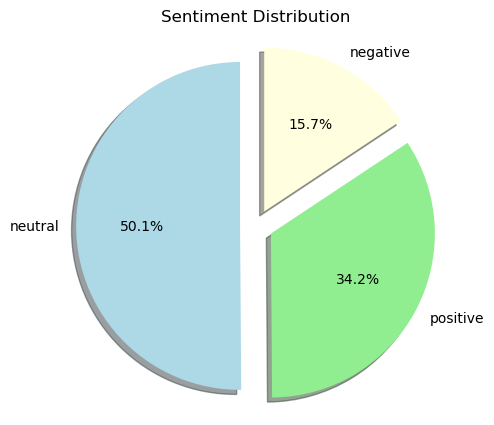

In [27]:
# Call the function to plot the sentiment distribution for the 'df_train' DataFrame.
plot_sentiment_pie(df_train)

In [28]:
# Define a function to plot a bar chart showing the distribution of tweets among sentiment classes.
def plot_sentiment_bar(data):
    # Extract the counts of each sentiment category and their corresponding labels from the 'sentiments' column.
    sentiment_counts = data['sentiments'].value_counts()
    # assign the index and values of each sentiment to the variables labels and counts
    labels = sentiment_counts.index
    counts = sentiment_counts.values
    
    # Create a figure for the bar chart with a specific size (6x5 inches).
    plt.figure(figsize=(6, 5))
    # Define a color palette for the bar chart using Seaborn.
    color_palette = sns.color_palette("dark")
    # Plot the bar chart using Seaborn, specifying the x-axis as sentiment labels and y-axis as tweet counts.
    ax = sns.barplot(x=labels, y=counts, palette=color_palette)
    # Add labels and a title to the plot.
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Tweets')
    plt.title('Number of Tweets per Sentiment')

    # Loop through the individual bars in the chart to annotate each bar with its count.
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    # Display the bar chart.
    plt.show()

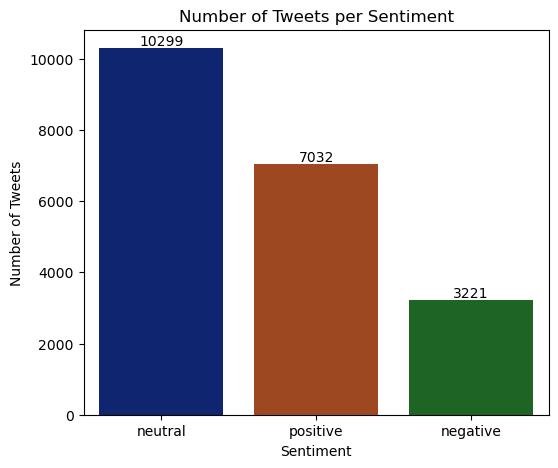

In [29]:
# Call the function to plot the sentiment distribution for the 'df_train' DataFrame.
plot_sentiment_bar(df_train)

In [30]:
# Define a function to plot a bar chart showing the distribution of the most common words in a given column of the data.
def plot_word_distribution(data, column):
    # Concatenate all text in the specified column into a single string.
    all_tweets = ' '.join(data[column].astype(str).values)
    # Split the text into individual words.
    words = all_tweets.split()
    # Count the frequency of each word and sort them in descending order.
    word_frequency = pd.Series(words).value_counts().sort_values(ascending=False)

    # Select the top 10 most frequent words.
    top_words = word_frequency.head(10)

    # Create a new figure with a specific size of 10 units in width and 6 units in height
    plt.figure(figsize=(10, 6))
    # Create a bar plot using seaborn (sns) where the x-axis represents the values (word frequencies) 
    # and the y-axis represents the words, with a dark color palette for styling
    sns.barplot(x=top_words.values, y=top_words.index, palette='dark')
    # Set the label for the x-axis
    plt.xlabel('Frequency')
    # Set the label for the y-axis
    plt.ylabel('Word')
    # Set the title of the plot
    plt.title('Word Distribution')
    # Display the plot
    plt.show()

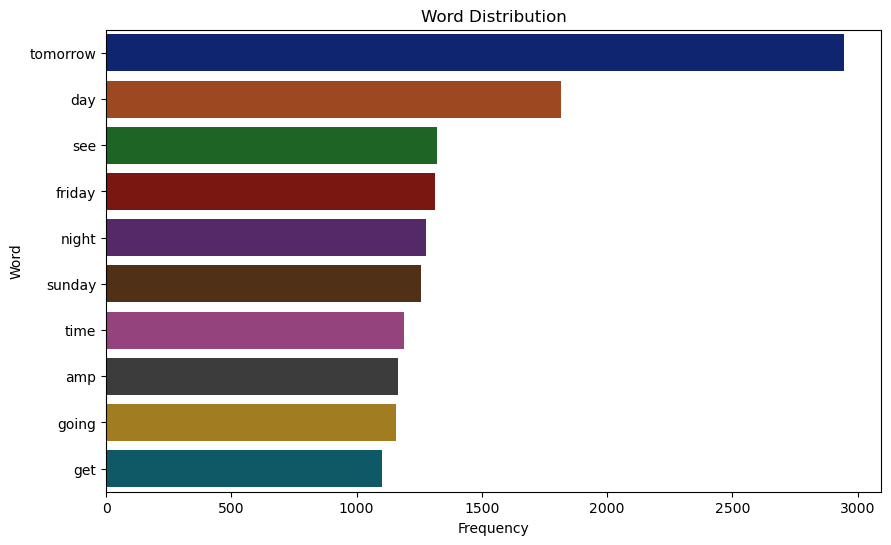

In [31]:
# Call the function to plot word distribution for the 'clean_tweets' column of the 'df_train' DataFrame.
plot_word_distribution(df_train, 'clean_tweets')

In [32]:
# Define a function to generate word clouds for each sentiment category in the training dataset.
def generate_word_clouds(dataframe, sentiment_column, tweet_column):
    # Get unique sentiment categories present in the specified column.
    sentiment_category = dataframe[sentiment_column].unique()
    
    # Iterate through each sentiment category.
    for sentiment in sentiment_category:
        # Filter tweets that belong to the current sentiment category.
        tweets = dataframe[dataframe[sentiment_column] == sentiment][tweet_column]
        # Ensure all tweet entries are treated as strings.
        tweets = tweets.astype(str)
        
        # Combine all tweets into a single text string.
        text = " ".join(tweets)
        
        # Generate a word cloud with specified settings.
        wordcloud = WordCloud(height=800, width=800, background_color="black").generate(text)
        
        # Create a figure for displaying the word cloud.
        plt.figure(figsize=(10, 6))
        # Display the word cloud image using bilinear interpolation.
        plt.imshow(wordcloud, interpolation='bilinear')
        # Set a title for the word cloud based on the current sentiment.
        plt.title(f"wordcloud-{sentiment}")
        # Turn off axis labels.
        plt.axis('off')
        # Show the word cloud plot.

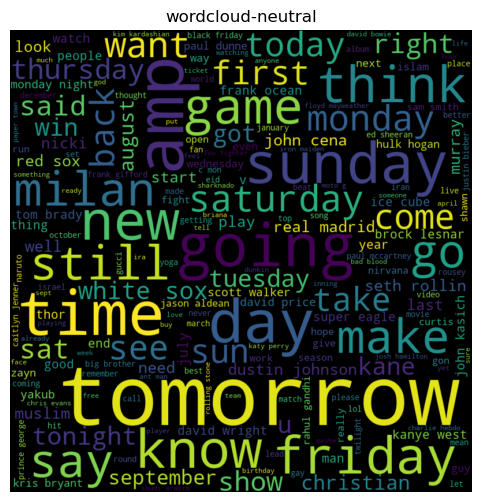

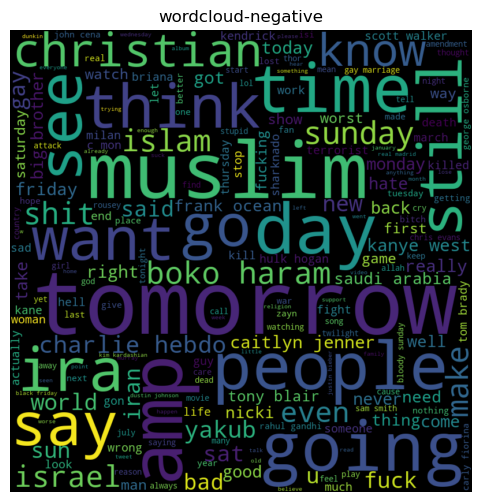

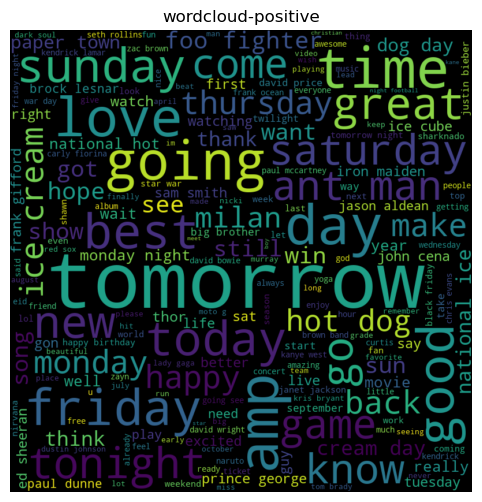

In [33]:
# Call the function to generate word clouds for sentiments using the 'df_train' DataFrame.
generate_word_clouds(df_train, 'sentiments', 'clean_tweets')

## Data Exploration of Test Data

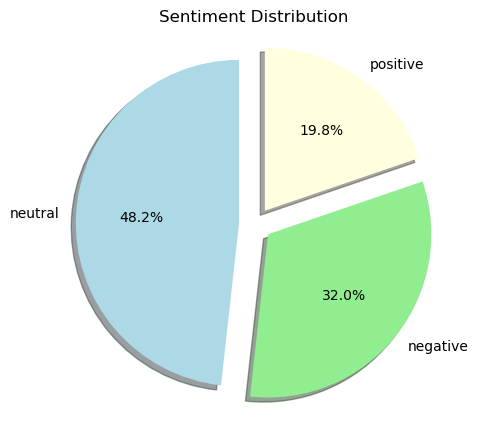

In [34]:
# Call the function to plot the sentiment distribution for the 'df_test' DataFrame.
plot_sentiment_pie(df_test)

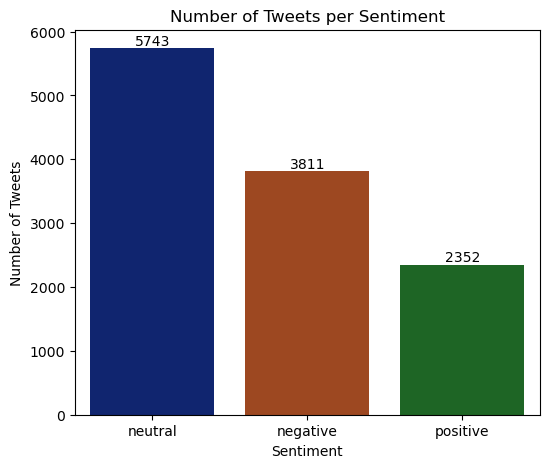

In [35]:
# Call the function to plot the sentiment distribution for the 'df_test' DataFrame.
plot_sentiment_bar(df_test)

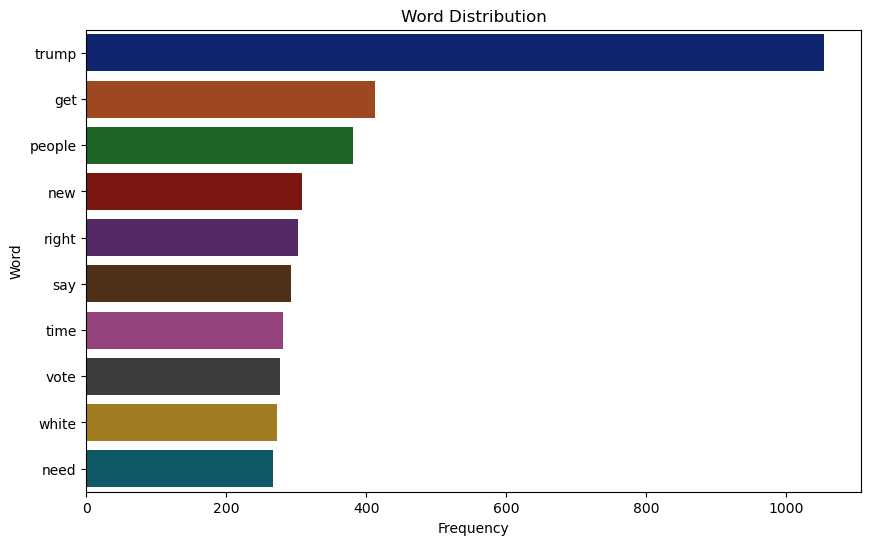

In [36]:
# Call the function to plot word distribution for the 'clean_tweets' column of the 'df_test' DataFrame.
plot_word_distribution(df_test, 'clean_tweets')